In [ ]:
!pip install qiskit
!pip install dwave-ocean-sdk
!pip install dwave-qiskit-plugin

In [ ]:
!dwave setup

In [ ]:
# Load the packages that are required
import numpy as np
import operator
import matplotlib.pyplot as plt
 
import sys
if sys.version_info < (3, 6):
    raise Exception('Please use Python version 3.6 or greater.')
 
try:
    import cplex
    from cplex.exceptions import CplexError
except: 
    print("Warning: Cplex not found.")
import math
 
# Qiskit packages
from qiskit import BasicAer
from qiskit.quantum_info import Pauli
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.operators import WeightedPauliOperator
 
# setup aqua logging
import logging
from qiskit.aqua._logging import set_logging_config, build_logging_config
#set_logging_config(build_logging_config(logging.DEBUG))  # choose INFO, DEBUG to see the log

In [ ]:
# Initialize the problem by defining the parameters
n = 3  # number of nodes + depot (n+1)
K = 2  # number of vehicles

In [ ]:
# Get the data
class Initializer():

    def __init__(self, n):
        self.n = n

    def generate_instance(self):

        n = self.n

        # np.random.seed(33)
        np.random.seed(1543)

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2
                instance[jj, ii] = instance[ii, jj]

        return xc, yc, instance

In [ ]:
# Initialize the problem by randomly generating the instance
initializer = Initializer(n)
xc,yc,instance = initializer.generate_instance()

In [ ]:
class ClassicalOptimizer:

    def __init__(self, instance,n,K):

        self.instance = instance
        self.n = n  # number of nodes
        self.K = K  # number of vehicles


    def compute_allowed_combinations(self):
        f = math.factorial
        return f(self.n) / f(self.K) / f(self.n-self.K)


    def cplex_solution(self):

        # refactoring
        instance = self.instance
        n = self.n
        K = self.K

        my_obj = list(instance.reshape(1, n**2)[0])+[0. for x in range(0,n-1)]
        my_ub = [1 for x in range(0,n**2+n-1)]
        my_lb = [0 for x in range(0,n**2)] + [0.1 for x in range(0,n-1)]
        my_ctype = "".join(['I' for x in range(0,n**2)]) + "".join(['C' for x in range(0,n-1)])

        my_rhs = 2*([K] + [1 for x in range(0,n-1)]) + [1-0.1 for x in range(0,(n-1)**2-(n-1))] + [0 for x in range(0,n)]
        my_sense = "".join(['E' for x in range(0,2*n)]) + "".join(['L' for x in range(0,(n-1)**2-(n-1))])+"".join(['E' for x in range(0,n)])

        try:
            my_prob = cplex.Cplex()
            self.populatebyrow(my_prob,my_obj,my_ub,my_lb,my_ctype,my_sense,my_rhs)

            my_prob.solve()

        except CplexError as exc:
            print(exc)
            return

        x = my_prob.solution.get_values()
        x = np.array(x)
        cost = my_prob.solution.get_objective_value()

        return x,cost
    

    def populatebyrow(self,prob,my_obj,my_ub,my_lb,my_ctype,my_sense,my_rhs):

        n = self.n
    
        prob.objective.set_sense(prob.objective.sense.minimize)
        prob.variables.add(obj = my_obj, lb = my_lb, ub = my_ub, types = my_ctype)
    
        prob.set_log_stream(None)
        prob.set_error_stream(None)
        prob.set_warning_stream(None)
        prob.set_results_stream(None)

        rows = []
        for ii in range(0,n):
            col = [x for x in range(0+n*ii,n+n*ii)]
            coef = [1 for x in range(0,n)]
            rows.append([col, coef])

        for ii in range(0,n):
            col = [x for x in range(0+ii,n**2,n)]
            coef = [1 for x in range(0,n)]

            rows.append([col, coef])

        # Sub-tour elimination constraints:
        for ii in range(0, n):
            for jj in range(0,n):
                if (ii != jj)and(ii*jj>0):

                    col = [ii+(jj*n), n**2+ii-1, n**2+jj-1]
                    coef = [1, 1, -1]

                    rows.append([col, coef])

        for ii in range(0,n):
            col = [(ii)*(n+1)]
            coef = [1]
            rows.append([col, coef])

        prob.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)

In [ ]:
# Instantiate the classical optimizer class
classical_optimizer = ClassicalOptimizer(instance,n,K)

# Print number of feasible solutions
print('Number of feasible solutions = ' + str(classical_optimizer.compute_allowed_combinations()))

Number of feasible solutions = 3.0


In [ ]:
# Solve the problem in a classical fashion via CPLEX
x = None
z = None
try:
    x,classical_cost = classical_optimizer.cplex_solution()
    # Put the solution in the z variable
    z = [x[ii] for ii in range(n**2) if ii//n != ii%n]
    # Print the solution
    print(z)
except: 
    print("CPLEX may be missing.")

CPLEX may be missing.


In [ ]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color='r')
    plt.plot(xc[0], yc[0], 'r*', ms=20)

    plt.grid()

    for ii in range(0, n ** 2):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], length_includes_head=True, head_width=.25)

    plt.title(title_str+' cost = ' + str(int(C * 100) / 100.))
    plt.show()    

if x is not None:
    visualize_solution(xc, yc, x, classical_cost, n, K, 'Classical')

In [ ]:
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import MinimumEigenOptimizer


class QuantumOptimizer:

    def __init__(self, instance, n, K):

        self.instance = instance
        self.n = n
        self.K = K

    def binary_representation(self,x_sol=0):

        instance = self.instance
        n = self.n
        K = self.K

        A = np.max(instance) * 100  # A parameter of cost function

        # Determine the weights w
        instance_vec = instance.reshape(n ** 2)
        w_list = [instance_vec[x] for x in range(n ** 2) if instance_vec[x] > 0]
        w = np.zeros(n * (n - 1))
        for ii in range(len(w_list)):
            w[ii] = w_list[ii]

        # Some variables I will use
        Id_n = np.eye(n)
        Im_n_1 = np.ones([n - 1, n - 1])
        Iv_n_1 = np.ones(n)
        Iv_n_1[0] = 0
        Iv_n = np.ones(n-1)
        neg_Iv_n_1 = np.ones(n) - Iv_n_1

        v = np.zeros([n, n*(n-1)])
        for ii in range(n):
            count = ii-1
            for jj in range(n*(n-1)):

                if jj//(n-1) == ii:
                    count = ii

                if jj//(n-1) != ii and jj%(n-1) == count:
                    v[ii][jj] = 1.

        vn = np.sum(v[1:], axis=0)

        # Q defines the interactions between variables
        Q = A*(np.kron(Id_n, Im_n_1) + np.dot(v.T, v))

        # g defines the contribution from the individual variables
        g = w - 2 * A * (np.kron(Iv_n_1,Iv_n) + vn.T) - \
                2 * A * K * (np.kron(neg_Iv_n_1, Iv_n) + v[0].T)

        # c is the constant offset
        c = 2 * A * (n-1) + 2 * A * (K ** 2)

        try:
            max(x_sol)
            # Evaluates the cost distance from a binary representation of a path
            fun = lambda x: np.dot(np.around(x), np.dot(Q, np.around(x))) + np.dot(g, np.around(x)) + c
            cost = fun(x_sol)
        except:
            cost = 0

        return Q, g, c, cost

    def construct_problem(self, Q, g, c) -> QuadraticProgram:
        qp = QuadraticProgram()
        for i in range(n * (n - 1)):
            qp.binary_var(str(i))
        qp.objective.quadratic = Q
        qp.objective.linear = g
        qp.objective.constant = c
        return qp
    
    def solve_problem(self, qp):
        aqua_globals.random_seed = 10598
        quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'), #pick a backend.
                                           seed_simulator=aqua_globals.random_seed,
                                           seed_transpiler=aqua_globals.random_seed)

        vqe = VQE(quantum_instance=quantum_instance)
        optimizer = MinimumEigenOptimizer(min_eigen_solver=vqe)
        result = optimizer.solve(qp)
        # compute cost of the obtained result
        _,_,_,level = self.binary_representation(x_sol=result.x)
        return result.x, level

/usr/local/lib/python3.7/dist-packages/qiskit/optimization/__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('optimization', 'qiskit_optimization', 'qiskit-optimization')


In [ ]:
# Instantiate the quantum optimizer class with parameters: 
quantum_optimizer = QuantumOptimizer(instance, n, K)

In [ ]:
# Check if the binary representation is correct
try:
    if z is not None:
        Q, g, c, binary_cost = quantum_optimizer.binary_representation(x_sol = z)
        print("Binary cost:", binary_cost, "classical cost:", classical_cost)
        if np.abs(binary_cost - classical_cost) < 0.01:
            print('Binary formulation is correct')
        else: print('Error in the binary formulation')
    else:
        print('Could not verify the correctness, due to CPLEX solution being unavailable.')
        Q, g, c, binary_cost = quantum_optimizer.binary_representation()
        print("Binary cost:", binary_cost)
except NameError as e:
    print("Warning: Please run the cells above first.")
    print(e)

print(Q)
print('next')
print(g)
print('next')
print(c)

In [ ]:
qp = quantum_optimizer.construct_problem(Q, g, c)
print(qp)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 36732.582303548450 x1 - 36789.172914567855 x2 - 36732.582303548450 x3
      - 24486.375107484597 x4 - 36789.172914567855 x5 - 24486.375107484597 x6 +
      [ 24529.270319564908 x1^2 + 24529.270319564908 x1*x2
      + 24529.270319564908 x1*x6 + 24529.270319564908 x2^2
      + 24529.270319564908 x2*x4 + 24529.270319564908 x3^2
      + 24529.270319564908 x3*x4 + 24529.270319564908 x3*x5
      + 24529.270319564908 x4^2 + 24529.270319564908 x5^2
      + 24529.270319564908 x5*x6 + 24529.270319564908 x6^2 ]/2 +
      73587.810958694725
Subject To

Bounds
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1
 0 <= x5 <= 1
 0 <= x6 <= 1

Binaries
 x1 x2 x3 x4 x5 x6
End



In [ ]:
quantum_solution, quantum_cost = quantum_optimizer.solve_problem(qp)

print(quantum_solution, quantum_cost)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
/usr/local/lib/python3.7/dist-packages/qiskit/aqua/quantum_instance.py:137: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')
/usr/local/lib/python3.7/dist-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/

[1. 1. 1. 0. 1. 0.] 132.11148115684045


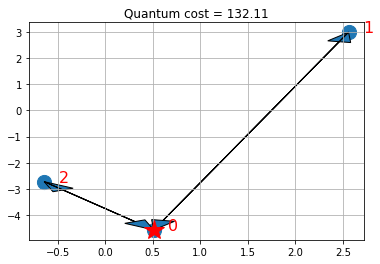

In [ ]:
# Put the solution in a way that is compatible with the classical variables
x_quantum = np.zeros(n**2)
kk = 0
for ii in range(n ** 2):
    if ii // n != ii % n:
        x_quantum[ii] = quantum_solution[kk]
        kk +=  1


# visualize the solution 
visualize_solution(xc, yc, x_quantum, quantum_cost, n, K, 'Quantum')
                   
# and visualize the classical for comparison
if x is not None:
    visualize_solution(xc, yc, x, classical_cost, n, K, 'Classical')

#Optimization using DWAVE through DWave-qiskit-plugin 

#DWave Quantum optimizer:
##class DQuantumOptimizer

In [ ]:



class DQuantumOptimizer:

    def __init__(self, instance, n, K):

        self.instance = instance
        self.n = n
        self.K = K

    def binary_representation(self,x_sol=0):

        instance = self.instance
        n = self.n
        K = self.K

        A = np.max(instance) * 100  # A parameter of cost function

        # Determine the weights w
        instance_vec = instance.reshape(n ** 2)
        w_list = [instance_vec[x] for x in range(n ** 2) if instance_vec[x] > 0]
        w = np.zeros(n * (n - 1))
        for ii in range(len(w_list)):
            w[ii] = w_list[ii]

        # Some variables I will use
        Id_n = np.eye(n)
        Im_n_1 = np.ones([n - 1, n - 1])
        Iv_n_1 = np.ones(n)
        Iv_n_1[0] = 0
        Iv_n = np.ones(n-1)
        neg_Iv_n_1 = np.ones(n) - Iv_n_1

        v = np.zeros([n, n*(n-1)])
        for ii in range(n):
            count = ii-1
            for jj in range(n*(n-1)):

                if jj//(n-1) == ii:
                    count = ii

                if jj//(n-1) != ii and jj%(n-1) == count:
                    v[ii][jj] = 1.

        vn = np.sum(v[1:], axis=0)

        # Q defines the interactions between variables
        Q = A*(np.kron(Id_n, Im_n_1) + np.dot(v.T, v))

        # g defines the contribution from the individual variables
        g = w - 2 * A * (np.kron(Iv_n_1,Iv_n) + vn.T) - \
                2 * A * K * (np.kron(neg_Iv_n_1, Iv_n) + v[0].T)

        # c is the constant offset
        c = 2 * A * (n-1) + 2 * A * (K ** 2)

        try:
            max(x_sol)
            # Evaluates the cost distance from a binary representation of a path
            fun = lambda x: np.dot(np.around(x), np.dot(Q, np.around(x))) + np.dot(g, np.around(x)) + c
            cost = fun(x_sol)
        except:
            cost = 0

        return Q, g, c, cost

    def construct_problem(self, Q, g, c) -> QuadraticProgram:
        qp = QuadraticProgram()
        for i in range(n * (n - 1)):
            qp.binary_var(str(i))
        qp.objective.quadratic = Q
        qp.objective.linear = g
        qp.objective.constant = c
        return qp
    
    def solve_problem(self, qp):
        aqua_globals.random_seed = 10598
        # quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'),
        #                                    seed_simulator=aqua_globals.random_seed,
        #                                    seed_transpiler=aqua_globals.random_seed)

        # vqe = VQE(quantum_instance=quantum_instance)
        # optimizer = MinimumEigenOptimizer(min_eigen_solver=vqe)
        # result = optimizer.solve(qp)
        dwave_mes = DWaveMinimumEigensolver()
        optimizer = MinimumEigenOptimizer(dwave_mes)
        result = optimizer.solve(qp)
        # compute cost of the obtained result
        _,_,_,level = self.binary_representation(x_sol=result.x)
        return result.x, level

In [ ]:
# Instantiate the quantum optimizer class with parameters: 
quantum_optimizer1 = DQuantumOptimizer(instance, n, K)

In [ ]:
# Check if the binary representation is correct
try:
    if z is not None:
        Q, g, c, binary_cost = quantum_optimizer1.binary_representation(x_sol = z)
        print("Binary cost:", binary_cost, "classical cost:", classical_cost)
        if np.abs(binary_cost - classical_cost) < 0.01:
            print('Binary formulation is correct')
        else: print('Error in the binary formulation')
    else:
        print('Could not verify the correctness, due to CPLEX solution being unavailable.')
        Q, g, c, binary_cost = quantum_optimizer1.binary_representation()
        print("Binary cost:", binary_cost)
except NameError as e:
    print("Warning: Please run the cells above first.")
    print(e)

Could not verify the correctness, due to CPLEX solution being unavailable.
Binary cost: 0


In [ ]:
qp1 = quantum_optimizer1.construct_problem(Q, g, c)

In [ ]:
from dwave.plugins.qiskit import DWaveMinimumEigensolver
quantum_solution1, quantum_cost1 = quantum_optimizer1.solve_problem(qp1)

print(quantum_solution1, quantum_cost1)

/usr/local/lib/python3.7/dist-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:38: DeprecationWarning: The package qiskit.aqua.algorithms.minimum_eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.minimum_eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')


[1. 1. 1. 0. 1. 0.] 132.11148115684045


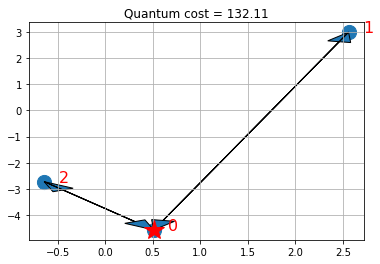

In [ ]:
# Put the solution in a way that is compatible with the classical variables
x_quantum = np.zeros(n**2)
kk = 0
for ii in range(n ** 2):
    if ii // n != ii % n:
        x_quantum[ii] = quantum_solution1[kk]
        kk +=  1


# visualize the solution 
visualize_solution(xc, yc, x_quantum, quantum_cost1, n, K, 'Quantum')
                   
# and visualize the classical for comparison
if x is not None:
    visualize_solution(xc, yc, x, classical_cost, n, K, 'Classical')

2 1
CPU times: user 485 ms, sys: 210 ms, total: 696 ms
Wall time: 3.77 s
[1. 1.] 39.25774423966868


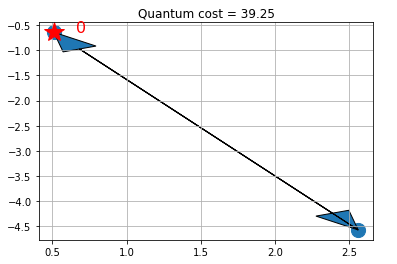

6 3
CPU times: user 1.65 s, sys: 297 ms, total: 1.95 s
Wall time: 4.93 s
[1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0.] 55.71219680234208


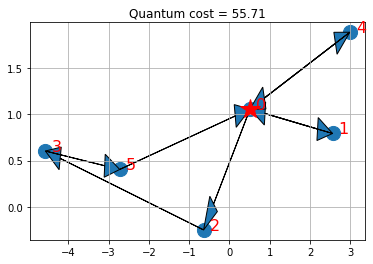

10 5
CPU times: user 28 s, sys: 242 ms, total: 28.3 s
Wall time: 31.4 s
[1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 79938.04831545136


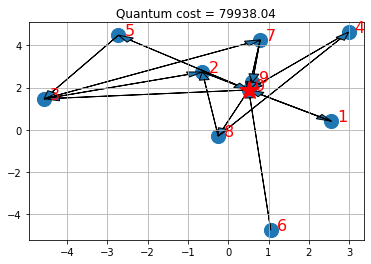

14 7
CPU times: user 2min 41s, sys: 675 ms, total: 2min 42s
Wall time: 2min 45s
[1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 97026.68280252255


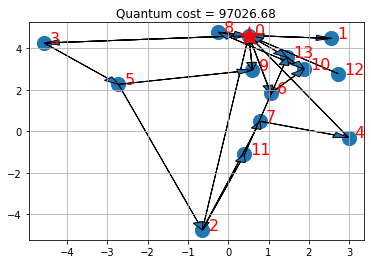

18 9


ValueError: ignored

In [ ]:
dwave_runtimes = []
for K in range(1,10,2):
  #for k in range(1,n):
  n =2*K
  print(n,K)
  initializer = Initializer(n)
  xc,yc,instance = initializer.generate_instance()
  quantum_optimizer1 = DQuantumOptimizer(instance, n, K)

  Q, g, c, binary_cost = quantum_optimizer1.binary_representation()
  # print("Binary cost:", binary_cost)

  #print(Q)
  qp1 = quantum_optimizer1.construct_problem(Q, g, c)

  #print(qp1)
  %time quantum_solution1, quantum_cost1 = quantum_optimizer1.solve_problem(qp1)
  print(quantum_solution1, quantum_cost1)
  dwave_runtimes.append(t)
  x_quantum = np.zeros(n**2)
  kk = 0
  for ii in range(n ** 2):
      if ii // n != ii % n:
          x_quantum[ii] = quantum_solution1[kk]
          kk +=  1


  # visualize the solution 
  visualize_solution(xc, yc, x_quantum, quantum_cost1, n, K, 'Quantum')
  

10 5
Could not verify the correctness, due to CPLEX solution being unavailable.
Binary cost: 0
[0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] 60079.53605377418


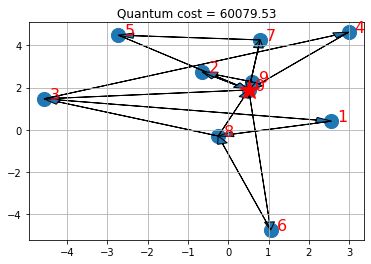

In [ ]:
n = 10
K = 5
print(n, K)
initializer = Initializer(n)
xc,yc,instance = initializer.generate_instance()
quantum_optimizer1 = DQuantumOptimizer(instance, n, K)
# Check if the binary representation is correct
try:
    if z is not None:
        Q, g, c, binary_cost = quantum_optimizer1.binary_representation(x_sol = z)
        print("Binary cost:", binary_cost, "classical cost:", classical_cost)
        if np.abs(binary_cost - classical_cost) < 0.01:
            print('Binary formulation is correct')
        else: print('Error in the binary formulation')
    else:
        print('Could not verify the correctness, due to CPLEX solution being unavailable.')
        Q, g, c, binary_cost = quantum_optimizer1.binary_representation()
        print("Binary cost:", binary_cost)
except NameError as e:
    print("Warning: Please run the cells above first.")
    print(e)

qp1 = quantum_optimizer1.construct_problem(Q, g, c)
# Runtime 25m 48s with following error
quantum_solution1, quantum_cost1 = quantum_optimizer1.solve_problem(qp1)

print(quantum_solution1, quantum_cost1)

# Put the solution in a way that is compatible with the classical variables
x_quantum = np.zeros(n**2)
kk = 0
for ii in range(n ** 2):
    if ii // n != ii % n:
        x_quantum[ii] = quantum_solution1[kk]
        kk +=  1


# visualize the solution 
visualize_solution(xc, yc, x_quantum, quantum_cost1, n, K, 'Quantum')
                   
# and visualize the classical for comparison
if x is not None:
    visualize_solution(xc, yc, x, classical_cost, n, K, 'Classical')

3 2
CPU times: user 512 ms, sys: 276 ms, total: 788 ms
Wall time: 4.52 s
[1. 1. 1. 0. 1. 0.] 132.11148115684045


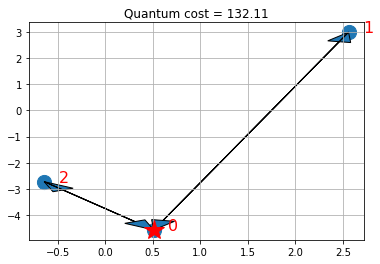

4 2
CPU times: user 1.09 s, sys: 306 ms, total: 1.4 s
Wall time: 5.03 s
[1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.] 124.87051695230184


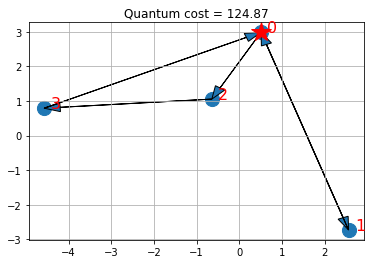

4 3
CPU times: user 582 ms, sys: 301 ms, total: 883 ms
Wall time: 4.55 s
[1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0.] 145.06617532123346


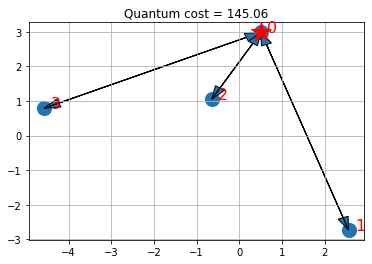

5 2
CPU times: user 792 ms, sys: 306 ms, total: 1.1 s
Wall time: 4.72 s
[0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.] 92.08651289119734


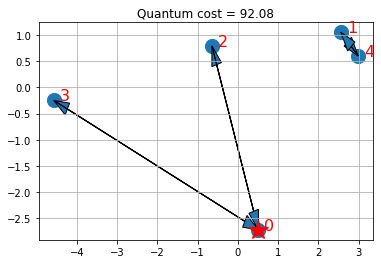

5 3
CPU times: user 847 ms, sys: 325 ms, total: 1.17 s
Wall time: 4.86 s
[1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.] 127.41191469447222


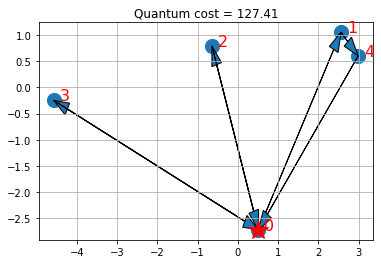

5 4
CPU times: user 829 ms, sys: 330 ms, total: 1.16 s
Wall time: 4.8 s
[1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.] 162.7373164978344


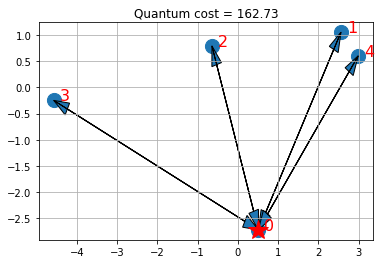

6 2
CPU times: user 1.77 s, sys: 339 ms, total: 2.11 s
Wall time: 5.75 s
[0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0.] 66.76664346770849


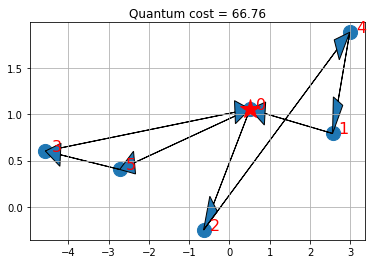

6 3
CPU times: user 1.54 s, sys: 322 ms, total: 1.87 s
Wall time: 5.52 s
[1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 0.] 55.71219680234208


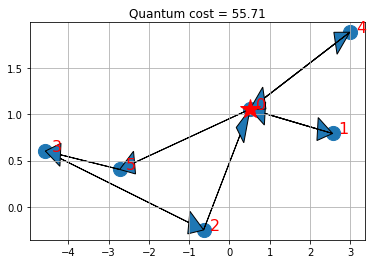

6 4
CPU times: user 1.67 s, sys: 355 ms, total: 2.02 s
Wall time: 5.66 s
[1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0.] 89.18340819279547


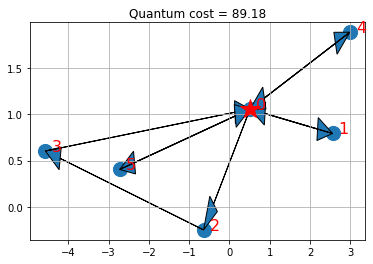

6 5
CPU times: user 1.44 s, sys: 349 ms, total: 1.79 s
Wall time: 5.41 s
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0.] 102.07931964821182


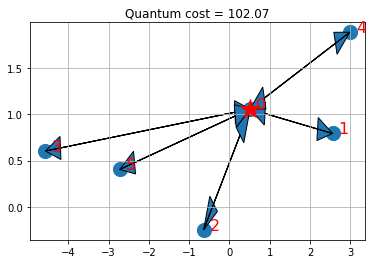

7 2
CPU times: user 3.17 s, sys: 438 ms, total: 3.61 s
Wall time: 7.13 s
[1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.] 80.20977869056514


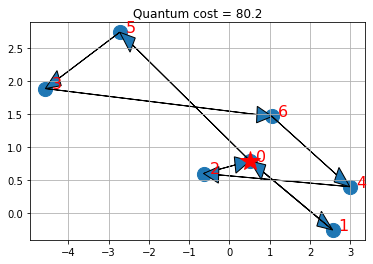

7 3
CPU times: user 4.29 s, sys: 469 ms, total: 4.76 s
Wall time: 8.35 s
[0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 77.48107020673342


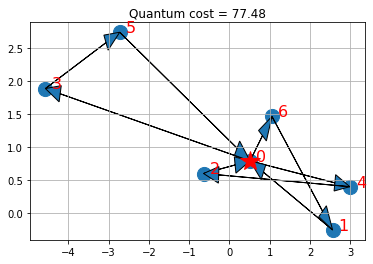

7 4
CPU times: user 3.44 s, sys: 458 ms, total: 3.9 s
Wall time: 14.7 s
[1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.] 35.62473070854321


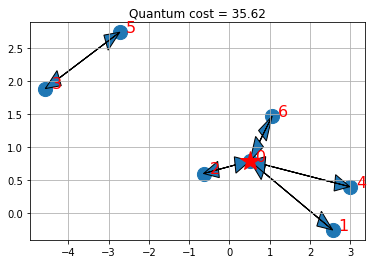

7 5
CPU times: user 3.18 s, sys: 458 ms, total: 3.64 s
Wall time: 10 s
[1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 107.70095521735493


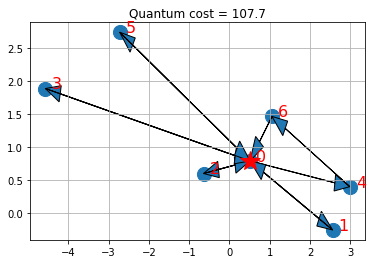

7 6
CPU times: user 3.49 s, sys: 464 ms, total: 3.96 s
Wall time: 7.55 s
[0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 11962.275213750254


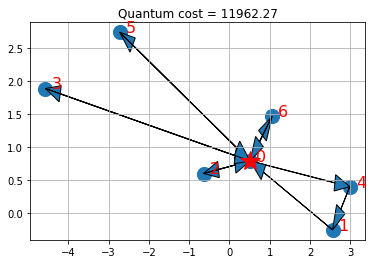

8 2
CPU times: user 7.76 s, sys: 414 ms, total: 8.18 s
Wall time: 11.8 s
[1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 1. 0. 0. 0.] 12621.973217419174


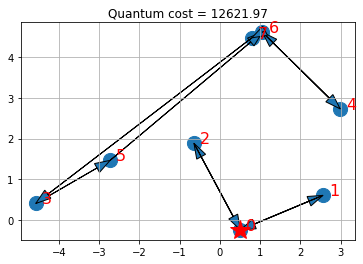

8 3
CPU times: user 6.68 s, sys: 442 ms, total: 7.12 s
Wall time: 10.8 s
[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0.] 234.34927150406293


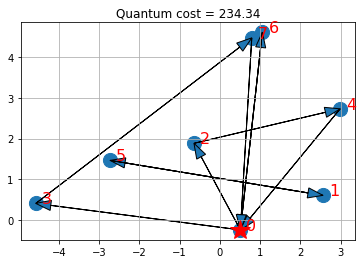

8 4
CPU times: user 7.9 s, sys: 501 ms, total: 8.4 s
Wall time: 12.1 s
[0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0.] 12691.089758316986


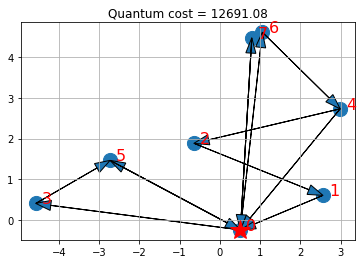

8 5
CPU times: user 8.57 s, sys: 444 ms, total: 9.01 s
Wall time: 12.9 s
[1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0.] 12664.286069331167


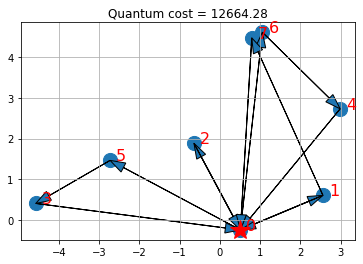

8 6
CPU times: user 7 s, sys: 453 ms, total: 7.45 s
Wall time: 11.1 s
[1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1.] 177.58014014619403


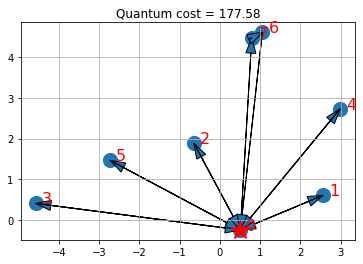

8 7
CPU times: user 9.1 s, sys: 496 ms, total: 9.59 s
Wall time: 13.3 s
[1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0.] 12728.299667782616


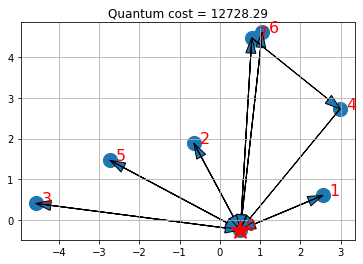

9 2
CPU times: user 15.3 s, sys: 537 ms, total: 15.9 s
Wall time: 19.6 s
[0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 20323.503419181972


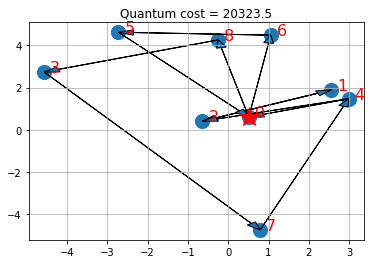

9 3
CPU times: user 14.6 s, sys: 573 ms, total: 15.2 s
Wall time: 18.8 s
[0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] 20272.4759471094


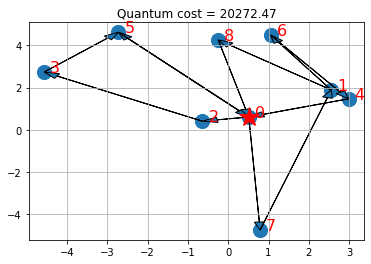

9 4
CPU times: user 14 s, sys: 545 ms, total: 14.6 s
Wall time: 18.2 s
[0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] 20339.69157034671


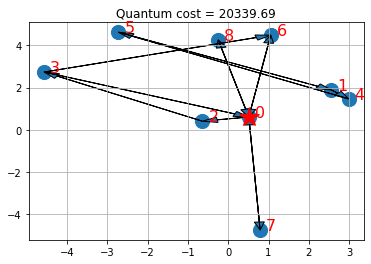

9 5
CPU times: user 15.9 s, sys: 614 ms, total: 16.5 s
Wall time: 20.2 s
[0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 20326.406360209454


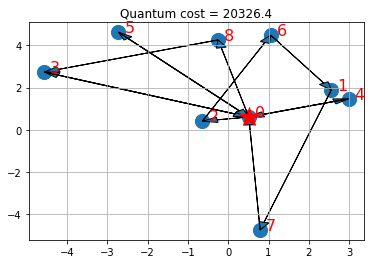

9 6
CPU times: user 13.6 s, sys: 576 ms, total: 14.1 s
Wall time: 17.8 s
[1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 40357.285997427185


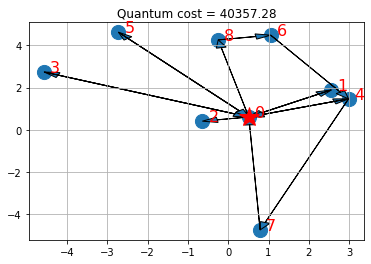

9 7
CPU times: user 15.8 s, sys: 621 ms, total: 16.4 s
Wall time: 20 s
[1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] 20309.692291536834


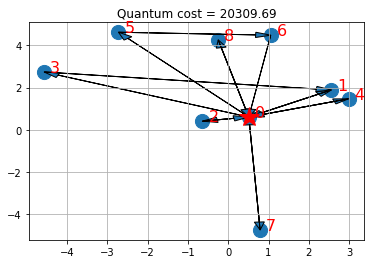

9 8
CPU times: user 16.2 s, sys: 603 ms, total: 16.9 s
Wall time: 20.5 s
[1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.] 60530.46665183641


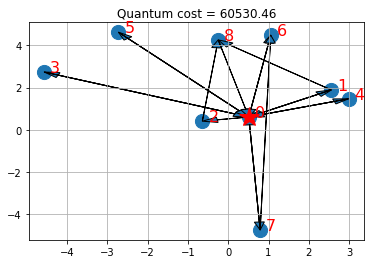

In [ ]:
dwave_runtimes = []
for n in range(2,10,1):
  for K in range(2,n):
    
    print(n,K)
    initializer = Initializer(n)
    xc,yc,instance = initializer.generate_instance()
    quantum_optimizer1 = DQuantumOptimizer(instance, n, K)

    Q, g, c, binary_cost = quantum_optimizer1.binary_representation()
    # print("Binary cost:", binary_cost)

    #print(Q)
    qp1 = quantum_optimizer1.construct_problem(Q, g, c)

    #print(qp1)
    %time quantum_solution1, quantum_cost1 = quantum_optimizer1.solve_problem(qp1)
    print(quantum_solution1, quantum_cost1)
    x_quantum = np.zeros(n**2)
    kk = 0
    for ii in range(n ** 2):
        if ii // n != ii % n:
            x_quantum[ii] = quantum_solution1[kk]
            kk +=  1


    # visualize the solution 
    visualize_solution(xc, yc, x_quantum, quantum_cost1, n, K, 'Quantum')